In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random
import seaborn as sns

In [113]:
!pip install seaborn

## Funkcje pomocnicze

In [2]:
# Zmienia format daty z sekund na rrrr-mm-dd
def dataformat(data):
    new_data = time.localtime(data)
    if new_data.tm_mday<10:
        data_day = '0'+str(new_data.tm_mday)
    else:
        data_day = str(new_data.tm_mday)
        
    if new_data.tm_mon<10:
        data_mon = '0' + str(new_data.tm_mon)
    else:
        data_mon =  str(new_data.tm_mon)

    g_data = str(new_data.tm_year) + '-' +data_mon + '-' + data_day
    
    return(g_data)
    

In [3]:
def add_salary(zatr, zwo, pensja):
    zatr_time = time.localtime(zatr)
    #10 sa wyplaty
    if zatr_time.tm_mday<10:
        fir_mon = zatr_time.tm_mon
    else:
        fir_mon = zatr_time.tm_mon+1
    #pierwsza wyplata
    zatr_sec = time.mktime((zatr_time.tm_year, fir_mon, 10, 17, 3, 38, 1, 48, 0))
    pierwsza_pensja = np.round(((zatr_sec - zatr)/(3600*24))*(pensja/30),2)
    zwo_time = time.localtime(zwo)
    if zwo_time.tm_mday<10:
        las_mon = zwo_time.tm_mon
    else:
        las_mon = zwo_time.tm_mon+1
    #ostatnia wyplata
    zwo_sec = time.mktime((zwo_time.tm_year, las_mon, 10, 17, 3, 38, 1, 48, 0))
    ostatnia_pensja = abs(np.round((zwo_sec - zwo)/(3600*24)*(1-(pensja/30)),2))
    wyplata = zatr_sec+np.random.uniform(29.5,31.5)*24*3600
    pensje =[]
    daty = []
    daty.append(dataformat(zatr_sec))
    pensje.append(pierwsza_pensja)
    while wyplata < zwo:
        daty.append(dataformat(wyplata))
        pensje.append(pensja)
        wyplata += 30.5*24*3600
    daty.append(dataformat(zwo_sec))
    pensje.append(ostatnia_pensja)
    return(daty, pensje)

In [4]:
# generuje id, first-pierwsza wartosc, second-druga, i -koncowka
def id_generator(i, first = 0, second= 0, third = 0):
    if i<10:
        n_id = str(first)+str(second)+str(third)+'00'+str(i)
    elif i<100 and i >=10 :
        n_id = str(first)+str(second)+str(third)+'0'+str(i)
    elif i<1000 and i>=100:
        n_id = str(first)+str(second)+str(third)+str(i)
    elif i<10000 and i>=1000:
        n_id = str(first)+str(second)+str(i)
    return(n_id)

## Klasa zwierzę

In [5]:
class Animal:
    def __init__(self, species):
        
        self.species = species
        
        if self.species == 'pies':
            self.years = 15
            #sample from normal distribution with mean 6 and variance 3 - age of species
            self.mi = 4
            self.sigma = 3
            
        elif self.species == 'kot':
            self.years = 16
            self.mi = 2
            self.sigma = 4
            
        elif self.species == 'szczur':
            self.years = 2.5
            self.mi = 1.25
            self.sigma = 0.5
        self.wizyty = []
        self.daty_wizyt = []
        self.ceny = []
    def stan_zdrowia(self):
        ost_data_wiz = self.daty_wizyt[-1]
        if ost_data_wiz+7*24*3600 < self.actual_time:
            rand = np.random.random()
            if rand > 0.1:
                stan_zdr = "zdrowy"
            else:
                stan_zdr = "chory"
        else:
            stan_zdr = "w czasie leczenia" 
            
        self.stan_zdr = stan_zdr
        return(self.stan_zdr)
        
    def Wizyty(self, ad_time = None): 
        
        ost_data_wizyty = self.daty_wizyt[-1]
        choroby = ["przeziębienie", "zapalenie uszu","świeżb", "zapalenie spojówek","skaleczenie", "inne"]
        if ad_time is not None:
            data_wiz = np.random.uniform(ost_data_wizyty+24*3600, ad_time-24*3600)
        else:
            data_wiz = np.random.uniform(ost_data_wizyty+24*3600, self.actual_time-24*3600)
        zalec = "lek"
        self.daty_wizyt.append(data_wiz)
        chor = choroby[int(np.random.uniform(0, len(choroby)))]
        self.wizyty.append(chor)
        cena = int(np.round(np.random.uniform(50, 150),0))
        self.ceny.append(cena)
        return(data_wiz, chor, zalec, cena) 
    
    def choroby(self):
        
        return(self.wizyty, self.daty_wizyt, self.ceny)
    
    def Species(self):
        if self.species == "pies":
            self.species_id = 1
        elif self.species == "kot":
            self.species_id = 2
        elif self.species == "szczur":
            self.species_id = 3
            
        return(self.species_id)
    
    def plec(self):
        
        rand = np.random.random()
        if rand > 0.5:
            plec = "samica"
        else:
            plec = "samiec"
            
        self.plec = plec
        return(plec)
            
    def name(self, file):
        
        df = pd.read_csv(file, names = ['samce', 'samice'], encoding='unicode_escape')
        df = df.loc[:503]
        
        if self.plec == "samica":
            df = df['samice']
        elif self.plec == "samiec":
            df = df['samce']
        
        rand = np.round(np.random.uniform(0,len(df)-1),0)
        name = (df.values)[int(rand)]
        self.name = name
        
        return(self.name)
        
    def umaszczenie(self):
        
        list_colours = ['bialy', 'czarny', 'szary', 'rudy','brazowy', 'bialo-czarny', 'biszkoptowy', 'bialo-rudy',
                        'bialo-brązowy','bialo-szary','inne']
        len_colours = len(list_colours)
        random_c = np.round(np.random.uniform(0,len_colours-1), 0)
        umaszczenie = list_colours[int(random_c)]
        
        self.umaszczenie = umaszczenie
        
        return(self.umaszczenie, self.species) 

    
    def birth(self, death_year = 0):
        
        years2sec = 365.25*24*3600
        self.actual_time = time.time() - death_year*years2sec  #actual time in second)
        begin_time = self.actual_time - self.years*years2sec #years- how many years back (in seconds)
        sec_mi = self.mi*years2sec
        sec_std = self.sigma*years2sec
        birth_date = np.random.normal(begin_time+sec_mi, (sec_std), 1)
        
        #looking for dates beetwen begin and actual time
        while begin_time > birth_date or self.actual_time < birth_date:
        
            birth_date  = np.random.normal(begin_time+sec_mi, (sec_std), 1)
            
        #birth date of animal    
        self.birth_date = birth_date
        
        return( self.birth_date , self.actual_time)
        
    def masa(self):
        #sprawdzam date urodzenia bo pies majacy 2 miesiace nie bedzie wazyl 40kg
        act = (time.localtime(self.actual_time))
        bir = (time.localtime(self.birth_date))
        if bir.tm_year == act.tm_year:
            if abs(bir.tm_mon-act.tm_mon) < 6:
                if self.species == 'pies':
                    masa = np.random.normal(5,5)
                    while masa < 0.5:
                        masa = np.random.normal(5,5)
                elif self.species == 'kot':
                    masa = np.random.normal(1,1)
                    while masa < 0.4 or masa > 2:
                        masa = np.random.normal(1,1)
                elif self.species == 'szczur':
                    masa = np.random.normal(0.1,0.2)
                    while masa < 0.1 or masa > 0.45:
                        masa = np.random.normal(0.1,0.2)
                
            else:
                if self.species == 'pies':
                    masa = np.random.normal(12,6)
                    while masa < 0.5 or masa > 30:
                        masa = np.random.normal(12,6)
                elif self.species == 'kot':
                    masa = np.random.normal(1,1.3)
                    while masa < 0.6 or masa > 3:
                        masa = np.random.normal(1,1.3)
                elif self.species == 'szczur':
                    masa = np.random.normal(0.2,0.2)
                    while masa < 0.24 or masa > 0.55:
                        masa = np.random.normal(0.2,0.2)
        else:
            if self.species == 'pies':
                masa = np.random.normal(17,7)
                while masa < 1 or masa > 45:
                    masa = np.random.normal(17,7)
            elif self.species == 'kot':
                masa = np.random.normal(3, 2)
                while masa < 1 or masa > 5:
                    masa = np.random.normal(3, 2)
            elif self.species == 'szczur':
                masa = np.random.normal(0.25,0.2)
                while masa < 0.24 or masa > 0.7:
                    masa = np.random.normal(0.25,0.2)
        self.masa  = np.round(masa, 3)

        return(self.masa)
    
    def acceptance(self, o_years = 3.21, accep=None): #3.21 years - opening of pound
        
        years2sec = 365.25*24*3600
        open_time = self.actual_time - o_years*years2sec
        if accep is None:
            if np.random.random()> 0.7:
                acc_time = np.random.uniform(open_time, open_time+0.3*years2sec)
            else:
                acc_time = np.random.uniform(open_time, self.actual_time)
#             acc_time = abs(np.random.normal(0, 24*3600))+open_time

#             while acc_time > self.actual_time or bool(acc_time < self.birth_date+50*24*3600):
#     #             print(acc_time > self.actual_time)
#     #             print(bool(acc_time < self.birth_date))
#                 acc_time = abs(np.random.normal(0, 800*24*3600))+open_time
        else:
            acc_time = time.mktime(time.strptime(accep, '%Y-%m-%d'))
            
        #print(time.localtime(acc_time))
        #acceptance date    
        self.acc_time = acc_time
        p_wizyta = acc_time+24*3600
        self.daty_wizyt.append(p_wizyta)
        self.wizyty.append("pierwsza wizyta")
        self.ceny.append(50)
        return( self.acc_time )
    
    def adoption(self):
        
        day2sec = 24*3600
        ad_time = np.random.uniform(self.acc_time+7*day2sec, self.actual_time-14*day2sec) 
          
        self.ad_time = ad_time
        #self.adoptujacy()
        
        return( self.ad_time )
    
#print(acc_time > self.actual_time)
#print(bool(acc_time < self.birth_date))
#print(time.localtime(acc_time))
#acceptance date  
    def adoptujacy(self, own_names, own_lastnames, own_streets, own_city):
        own_ind0 = int(np.round(np.random.uniform(0,len(own_names)),0)-1)
        own_ind1 = int(np.round(np.random.uniform(0,len(own_lastnames)),0)-1)
        own_ind2 = int(np.round(np.random.uniform(0,len(own_streets)),0)-1)
        own_name = own_names[own_ind0][0]
        own_lastname = own_lastnames[own_ind1][0]
        own_street = own_streets[own_ind2]+' ' + str(int(np.random.uniform(1,100)))
        own_tel = str(int(np.random.uniform(100,999)))+"-"
        own_tel = own_tel + str(int(np.random.uniform(100,999)))+"-"+str(int(np.random.uniform(100,999)))
        owner = {}
        owner['name'] = own_name
        owner['last_name'] = own_lastname
        owner['adres'] = own_street + ' ' + own_city
        owner['telefon'] = own_tel
        
        return(owner)
            
        
    def kastracja(self):
        rand = np.random.random()
        if rand > 0.1:
            self.kastracja = "tak"
            n_rand = np.random.random()
            if n_rand > 0.5:
                self.k_day = self.acc_time+ np.random.uniform(10,35)*24*3600
                self.daty_wizyt.append(self.k_day)
                self.wizyty.append("sterylizacja")
                self.ceny.append(200)
            else:
                self.k_day = self.birth_date + np.random.uniform(200,350)*24*3600

        else:
            self.kastracja = "nie"
            self.k_day = 0
        
        
        return(self.kastracja, self.k_day)
    def next_acceptance(self):
        day2sec = 24*3600
        new_acc_time = 0
        #20% zwierzakow wraca do schorniska
        if self.ad_time is not None:
            new_acc_time = np.random.uniform(self.ad_time+3*day2sec, self.actual_time-7*day2sec ) 
        #print(acc_time > self.actual_time)
        #print(bool(acc_time < self.birth_date))
        #print(time.localtime(acc_time))
        #acceptance date    
        self.acc_time = new_acc_time
        p_wizyta = self.acc_time+24*3600
        self.daty_wizyt.append(p_wizyta)
        self.wizyty.append("pierwsza wizyta")
        self.ceny.append(50)
        return( self.acc_time )
    
    
#sterylizacja - klasa zwierze - data wizty +1 dzien +tydzien sterylizacja
#0.01 0.01
#2 lata
#aktu -200
# wykladniczy ale od pewnego momentu z paramtrem 1
#masa ciała
#400 - 95% adotptowane , 5% zmarłe
#adopcje
# maks - 5, srednio -2, procent wracajacych - 30% 
# w wiekszosci darowizna, co miesiac -wyplaty, dotacja z urzedu
#imiona - nie powtarzaja sie - usuwam z listy uzyte imie


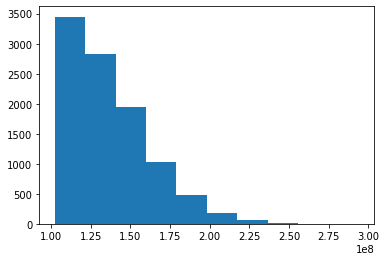

In [6]:
plt.hist(abs(np.random.normal(0, 500*24*3600,10000))+102344024)
plt.show()

In [7]:
years2sec = 365.25*24*3600
o_years = 3.21
open_time = time.time() - o_years*years2sec
acc_time = abs(np.random.normal(0, 800*24*3600))+open_time
dataformat(acc_time)

'2017-09-27'

## Funkcja pracownik

In [8]:
def pracownik(own_names, own_lastnames, own_streets, own_city, years=3.21):
        own_ind0 = int(np.round(np.random.uniform(0,len(own_names)),0)-1)
        own_ind1 = int(np.round(np.random.uniform(0,len(own_lastnames)),0)-1)
        own_ind2 = int(np.round(np.random.uniform(0,len(own_streets)),0)-1)
        own_name = own_names[own_ind0][0]
        own_lastname = own_lastnames[own_ind1][0]
        own_street = own_streets[own_ind2]+' ' + str(int(np.random.uniform(1,100)))
        own_tel = str(int(np.random.uniform(100,999)))+"-"
        own_tel = own_tel + str(int(np.random.uniform(100,999)))+"-"+str(int(np.random.uniform(100,999)))
        owner = {}
        owner['name'] = own_name
        owner['last_name'] = own_lastname
        owner['adres'] = own_street + ' ' + own_city
        owner['telefon'] = own_tel
        years2sec = 365.25*24*3600
        actual_time = time.time()
        open_time = actual_time - years*years2sec
        
        data_zat = np.random.uniform(open_time, actual_time)
        data_zw =  np.random.uniform(data_zat, actual_time+24*3600)
        owner["zatr"] = data_zat
        owner["zwoln"] = data_zw
        return(owner)

In [9]:
ulice = ['ul. Agrestowa',
'ul. Akacjowa',
'ul. Armii Krajowej',
'ul. Balonowa',
'ul. Batalionów Chłopskich',
'ul. gen. Józefa Bema',
'ul. Błękitna',
'ul. Bociania',
'ul. Jerzego Bocka',
'ul. Boczna',
'ul. Bolesława Krzywoustego',
'ul. Arkadiusza Bożka',
'ul. Bratnia',
'ul. Brzozowa',
'ul. Ceglana',
'ul. Fryderyka Chopina',
'ul. Cicha',
'ul. Ciepła',
'ul. Antoniego Cieszyńskiego',
'ul. Cmentarna',
'ul. Bronisława Czecha',
'ul. Ignacego Daszyńskiego',
'ul. Henryka Dąbrowskiego',
'ul. Demokratów',
'ul. Kazimierza Deyny',
'ul. Dobroszycka',
'ul. Energetyczna',
'ul. Fabryczna',
'ul. Gliniana',
'ul. Władysława Grabskiego',
'ul. Gryczana',
'ul. gen. Józefa Hallera',
'ul. św. Jadwigi',
'ul. Jagodowa',
'ul. Jaśminowa',
'ul. Jarzynowa',
'ul. Jasna',
'ul. Jastrzębia',
'ul. Jęczmienna',
'ul. Kasztanowa',
'ul. Kazimierza Wielkiego',
'ul. Jana Kilińskiego',
'ul. gen. Franciszka Kleeberga',
'ul. Klonowa',
'ul. Jana Kochanowskiego',
'ul. Kolejowa',
'ul. Kościelna',
'ul. Tadeusza Kościuszki',
'skwer Kombatantów Rzeczypospolitej',
'ul. Mikołaja Kopernika',
'ul. Kosynierów',
'ul. Krótka',
'ul. Kresowa',
'ul. Krucza',
'ul. Krzywa',
'ul. Janusza Kusocińskiego',
'ul. Eugeniusza Felicjana Kwiatkowskiego',
'ul. Kwiatowa',
'ul. Joachima Lelewela',
'ul. Leśna',
'ul. Leszczynowa',
'ul. Bolesława Limanowskiego',
'ul. Lipowa',
'ul. 11 Listopada',
'ul. Lotnicza',
'ul. Stefana Żeromskiego',
'ul. Żwirki i Wigury',
'ul. Żytnia',
'ul. Ludwikowska',
'ul. Lwowska',
'ul. Henryka Łasaka',
'ul. Łąkowa',
'ul. Łowiecka',
'ul. Łukanowska',
'ul. Łużycka',
'pl. Książąt Śląskich',
'ul. Tadeusza Ślusarskiego',
'ul. Świerkowa',
'ul. gen. Stanisława Maczka',
'ul. 3 Maja',
'ul. Malinowa',
'ul. Bronisława Malinowskiego',
'ul. Małopolna',
'ul. Jana Matejki',
'ul. Adama Mickiewicza',
'ul. Stanisława Mikołajczyka',
'ul. Miła',
'ul. Miodowa',
'ul. Młynarska',
'ul. Mokra',
'ul. Ignacego Mościckiego',
'ul. Stanisława Moniuszki',
'ul. Na Podkowie',
'ul. Gabriela Narutowicza',
'ul. Nowowiejska',
'ul. Ogrodowa',
'ul. Okrężna',
'ul. Orla',
'ul. Osada Bystre',
'ul. Osiedle',
'ul. Otwarta',
'ul. Owocowa',
'ul. Owsiana',
'ul. Ignacego Paderewskiego',
'ul. Parkowa',
'ul. Północna',
'ul. Pocztowa',
'ul. Podchorążych',
'ul. Pogodna',
'ul. Polna',
'ul. Południowa',
'ul. Księcia Józefa Poniatowskiego',
'ul. Poprzeczna',
'ul. Porzeczkowa',
'ul. Powietrzna',
'ul. Poziomkowa',
'ul. Prosta',
'ul. Bolesława Prusa',
'ul. Przemysłowa',
'ul. Kazimierza Przerwy-Tetmajera',
'ul. Przyjaźni',
'ul. Bogusława Psujka',
'ul. Pszeniczna',
'ul. Ptasia',
'ul. Kazimierza Pułaskiego',
'ul. Heleny Radlińskiej',
'ul. Różana',
'ul. Mikołaja Reja',
'ul. Tadeusza Rejtana',
'ul. Władysława Stanisława Reymonta',
'rondo Rondo Jana Pawła II',
'rondo Rondo Miast Partnerskich',
'ul. Wandy Rutkiewicz',
'ul. Rycerska',
'ul. Rzemieślnicza',
'ul. Rzepakowa',
'ul. Sejmowa',
'ul. Janusza Sidły',
'ul. Henryka Sienkiewicza',
'ul. gen. Władysława Sikorskiego',
'ul. Jana Sinapiusa',
'ul. Marii Skłodowskiej-Curie',
'ul. Słoneczna',
'ul. Juliusza Słowackiego',
'ul. Sokola',
'ul. Ignacego Solarza',
'rondo Solidarności',
'ul. Sosnowa',
'ul. Spacerowa',
'ul. Spadochronowa',
'ul. Spokojna',
'ul. Feliksa Stamma',
'ul. Jana Stapińskiego',
'pl. Stanisława Staszica',
'ul. Stawowa',
'ul. Stolarska'
'ul. mjr. Henryka Sucharskiego',
'ul. ks. Franciszka Sudoła',
'ul. Szkolna',
'ul. Szybowcowa',
'ul. Targowa',
'ul. Tęczowa',
'ul. Lwa Tołstoja',
'ul. Trakcyjna',
'ul. Romualda Traugutta',
'ul. Stanisławy Walasiewicz',
'ul. Wałowa',
'ul. Wały Jagiellońskie',
'ul. Wądoły',
'ul. Wąska',
'ul. Wesoła',
'ul. Wiejska',
'ul. Wielkopolna',
'ul. Wierzbowa',
'ul. Wikliniarska',
'ul. Wileńska',
'ul. Wiśniowa',
'ul. Wincentego Witosa',
'ul. Wojska Polskiego',
'ul. Wrocławska',
'ul. Wschodnia',
'ul. Wspólna',
'ul. Józefa Wybickiego',
'ul. Zakładowa',
'ul. Zamkowa',
'ul. Zielona'
]

In [10]:
# zmieniam polskie znaki w nazwach ulic
for i in range(len(ulice)):
    ulice[i] = ulice[i].replace('ą','a')
    ulice[i] = ulice[i].replace('ć','c')
    ulice[i] = ulice[i].replace('Ć','C')
    ulice[i] = ulice[i].replace('ę','e')
    ulice[i] = ulice[i].replace('ł','l')
    ulice[i] = ulice[i].replace('Ł','L')
    ulice[i] = ulice[i].replace('ń','n')
    ulice[i] = ulice[i].replace('Ń','N')
    ulice[i] = ulice[i].replace('ó','o')
    ulice[i] = ulice[i].replace('ś','s')
    ulice[i] = ulice[i].replace('Ś','S')
    ulice[i] = ulice[i].replace('ż','z')
    ulice[i] = ulice[i].replace('ź','z')
    ulice[i] = ulice[i].replace('Ż','Z')
    ulice[i] = ulice[i].replace('Ź','Z')

## Dane

In [11]:
names_male = pd.read_csv('./dane/n_male.csv', names = ['names'], encoding='unicode_escape')
names_female = pd.read_csv('./dane/n_female.csv', names = ['names'], encoding='unicode_escape')
lastnames_male = pd.read_csv('./dane/lastn_male.csv',names = ['names'], encoding='unicode_escape')
lastnames_female = pd.read_csv('./dane/lastn_female.csv',names = ['names'], encoding='unicode_escape')
miasta = ["Wroclaw", "Olesnica", "Opole"]
names_male = (names_male.values).tolist() 
lastnames_male = (lastnames_male.values).tolist()
names_female = (names_female.values).tolist() 
lastnames_female = (lastnames_female.values).tolist()

## Schronisko

In [12]:

transakcje = []

In [13]:
actual_time = time.time()
#tutaj zbieram dane o pracownikach
pr_id = []
o_years = 3.21 #lata działania schroniska

years2sec = 365.25*24*3600
#data otwarcia schroniska
open_time = actual_time - o_years*years2sec
zwolnienia  = []

## Pracownicy

### Byli opiekunowie

In [14]:
byli_opiekunowie = [] 
opiekunowie = []
for i in range(4):
    
    p_id = id_generator(i=i, first=2)
    rand = np.random.random()
    if rand>0.5:
        opiekun = pracownik(names_male, lastnames_male, ulice, "Wroclaw")
    else:
        opiekun = pracownik(names_female, lastnames_female, ulice, "Wroclaw")
    
    
    zwol = opiekun["zwoln"]
    pensja = 2500
    data, pensja = add_salary(open_time,zwol,pensja)
    for j in range(len(data)):
        trans = {}
        trans['data'] = data[j]
        trans['id_transakcji'] = id_generator(i=int('3'+str(i)+str(j)), first=5, second = 9, third = 6)
        trans['imie'] = opiekun['name']
        trans['nazwisko'] = opiekun['last_name']
        trans['kwota'] = 0-float(pensja[j])
        trans['tytul'] = 'wyplata - Opiekun'
        transakcje.append(trans)
    zatr = dataformat(open_time)
    zwolnienia.append(zwol)
    zwo = dataformat(zwol)
    opiekun_d = {'id':p_id, 'imie': opiekun['name'], 'nazwisko': opiekun['last_name'], 
               'adres': opiekun['adres'], 'telefon': opiekun['telefon'], 'zatrudnienie':zatr, "zwolenienie": zwo,
          'stanowisko': 'opiekun', 'pensja': 2500}
    byli_opiekunowie.append(opiekun_d)
    opiekunowie.append(opiekun_d)
    
    
df_byli = pd.DataFrame(data=byli_opiekunowie)
df_byli.head()

,adres,id,imie,nazwisko,pensja,stanowisko,telefon,zatrudnienie,zwolenienie
0,ul. gen. Stanislawa Maczka 27 Wroclaw,200000,KAROLINA,WYSOCZANSKA,2500,opiekun,587-513-488,2016-04-06,2018-12-27
1,ul. Henryka Dabrowskiego 30 Wroclaw,200001,BARTOSZ,WACHOWICZ,2500,opiekun,893-462-769,2016-04-06,2018-04-29
2,ul. Jozefa Wybickiego 95 Wroclaw,200002,KAZIMIERZ,KUZMA,2500,opiekun,193-235-874,2016-04-06,2018-05-18
3,ul. Jasminowa 98 Wroclaw,200003,KAZIMIERZ,KAWALEC,2500,opiekun,832-586-271,2016-04-06,2017-03-11


In [15]:
int(str(2)+str(3))

23

### Aktualni opiekunowie

In [16]:
#najpierw opiekunowie
#4 opiekunow pracuje aktualnie
for i in range(4):

    rand = np.random.random()
    if rand>0.5:
        opiekun = pracownik(names_male, lastnames_male, ulice, "Wroclaw")
    else:
        opiekun = pracownik(names_female, lastnames_female, ulice, "Wroclaw")
    zat = zwolnienia[i]+np.random.uniform(1,30)*24*3600
    zatr = dataformat(zat)
    pensja = 2500
    data, pensja = add_salary(zat,actual_time,pensja)
    for j in range(len(data)):
        trans = {}
        trans['data'] = data[j]
        trans['id_transakcji'] = id_generator(i=int('6'+str(i+3)+str(j)), first=5, second = 9, third =5)
        trans['imie'] = opiekun['name']
        trans['nazwisko'] = opiekun['last_name']
        trans['kwota'] = 0-float(pensja[j])
        trans['tytul'] = 'wyplata - Opiekun'
        transakcje.append(trans)
    zwo = "9999-99-99"
    p_id = id_generator(i=i, first=2)
    pr_id.append(p_id)
    opiekun_d = {'id':p_id, 'imie': opiekun['name'], 'nazwisko': opiekun['last_name'], 
               'adres': opiekun['adres'], 'telefon': opiekun['telefon'], 'zatrudnienie':zatr, "zwolenienie": zwo,
          'stanowisko': 'opiekun', 'pensja': 2500}
    opiekunowie.append(opiekun_d)


### Reszta pracowników

In [17]:
#kierowca, ksiegowy, kierownik, asystent kierownika -pracuja od poczatku
pensje = ['4500','3500','3500','3000','2800']
stanowiska = [ 'Kierownik', 'Asystent kierownika', 'Ksiegowy','Kierowca', 'Sprzataczka']
for i in range(5):
    p_id = id_generator(i=i, first=1)
    rand = np.random.random()
    if rand>0.5:
        opiekun = pracownik(names_male, lastnames_male, ulice, "Wroclaw")
    else:
        opiekun = pracownik(names_female, lastnames_female, ulice, "Wroclaw")
    
    data, pensja = add_salary(open_time,actual_time,eval(pensje[i]))
    for j in range(len(data)):
        trans = {}
        trans['data'] = data[j]
        trans['id_transakcji'] = id_generator(i=int('9'+str(i+5)+str(j)), first=5, second = 9, third =3)
        trans['imie'] = opiekun['name']
        trans['nazwisko'] = opiekun['last_name']
        trans['kwota'] = 0-float(pensja[j])
        trans['tytul'] = 'wyplata - '+str(stanowiska[i])
        transakcje.append(trans)
    zatr = dataformat(open_time)
    zwo = "9999-99-99"


    opiekun_d = {'id':p_id, 'imie': opiekun['name'], 'nazwisko': opiekun['last_name'], 
               'adres': opiekun['adres'], 'telefon': opiekun['telefon'], 'zatrudnienie':zatr, "zwolenienie": zwo,
          'stanowisko': stanowiska[i], 'pensja': pensje[i]}
    opiekunowie.append(opiekun_d)


In [18]:
(pd.DataFrame(data=opiekunowie)).head()

,adres,id,imie,nazwisko,pensja,stanowisko,telefon,zatrudnienie,zwolenienie
0,ul. gen. Stanislawa Maczka 27 Wroclaw,200000,KAROLINA,WYSOCZANSKA,2500,opiekun,587-513-488,2016-04-06,2018-12-27
1,ul. Henryka Dabrowskiego 30 Wroclaw,200001,BARTOSZ,WACHOWICZ,2500,opiekun,893-462-769,2016-04-06,2018-04-29
2,ul. Jozefa Wybickiego 95 Wroclaw,200002,KAZIMIERZ,KUZMA,2500,opiekun,193-235-874,2016-04-06,2018-05-18
3,ul. Jasminowa 98 Wroclaw,200003,KAZIMIERZ,KAWALEC,2500,opiekun,832-586-271,2016-04-06,2017-03-11
4,ul. Wroclawska 80 Wroclaw,200000,MATEUSZ,PRABUCKI,2500,opiekun,835-983-467,2019-01-25,9999-99-99


### Wolontariusze

In [19]:
#przez schronisko przewinelo sie 67 wolontariuszy
wolontariusze = []
for i in range(67):
    p_id = id_generator(i=i, first=4)
        
    rand = np.random.random()
    if rand>0.5:
        opiekun = pracownik(names_male, lastnames_male, ulice, "Wroclaw")
    else:
        opiekun = pracownik(names_female, lastnames_female, ulice, "Wroclaw")
        
    zatr = dataformat(opiekun['zatr'])
    
    
    zwol = opiekun["zwoln"]
    zwo = dataformat(zwol)
    
    if np.random.random() > 0.85:
        zwo = '9999-99-99'
    
    wolontariusz =  {'id':p_id, 'imie': opiekun['name'], 'nazwisko': opiekun['last_name'], 
               'adres': opiekun['adres'], 'telefon': opiekun['telefon'], 'zatrudnienie':zatr, 
                     "rezygnacja": zwo}
    wolontariusze.append(wolontariusz)


In [20]:
(pd.DataFrame(data=wolontariusze)).head()

,adres,id,imie,nazwisko,rezygnacja,telefon,zatrudnienie
0,ul. Romualda Traugutta 83 Wroclaw,400000,ALICJA,ZYSK,2019-01-20,403-368-205,2018-03-14
1,ul. Ludwikowska 91 Wroclaw,400001,FRANCISZEK,JEZAK,9999-99-99,686-935-475,2018-12-23
2,ul. Jeczmienna 43 Wroclaw,400002,ZBIGNIEW,SLAWEK,2018-10-07,730-638-864,2018-04-29
3,ul. Jana Kochanowskiego 67 Wroclaw,400003,WIESLAWA,SOLECKA,2019-04-12,161-956-231,2018-05-06
4,ul. Jozefa Wybickiego 20 Wroclaw,400004,KRYSTYNA,KOJ,2016-11-13,527-543-356,2016-09-21


### Weterynarze

In [21]:
# 3 weterynarzy
#najpierw opiekunowie
#4 opiekunow pracuje aktualnie
weterynarze =[] 
w_id = []
miastaW = ["Wroclaw", "Wroclaw", "Olesnica","Wroclaw"]
for i in range(4):
    rand = np.random.random()
    if rand>0.5:
        opiekun = pracownik(names_male, lastnames_male, ulice, miastaW[i])
    else:
        opiekun = pracownik(names_female, lastnames_female, ulice, miastaW[i])

    zatr = dataformat(open_time)
    zwo = "9999-99-99"
    p_id = id_generator(i=i, first=3)
    w_id.append(p_id)
    opiekun_d = {'id':p_id, 'imie': opiekun['name'], 'nazwisko': opiekun['last_name'], 
               'adres': opiekun['adres'], 'telefon': opiekun['telefon'], 'zatrudnienie':zatr, "zwolenienie": zwo,
          'stanowisko': 'weterynarz'}
    weterynarze.append(opiekun_d)


In [22]:
(pd.DataFrame(data=weterynarze)).head()

,adres,id,imie,nazwisko,stanowisko,telefon,zatrudnienie,zwolenienie
0,ul. Waly Jagiellonskie 10 Wroclaw,300000,WIKTOR,LYSIK,weterynarz,557-779-252,2016-04-06,9999-99-99
1,ul. Wladyslawa Grabskiego 75 Wroclaw,300001,FILIP,SITARZ,weterynarz,450-256-508,2016-04-06,9999-99-99
2,ul. Wladyslawa Stanislawa Reymonta 42 Olesnica,300002,KLAUDIA,MROWINSKA,weterynarz,171-466-856,2016-04-06,9999-99-99
3,ul. Henryka Lasaka 95 Wroclaw,300003,JAKUB,WINKLER,weterynarz,668-695-370,2016-04-06,9999-99-99


# Zwierzęta

### gatunki

In [90]:
#gatunki
gatunki = {'nazwa' : ['pies', 'kot', 'szczur'], 'id_gatunku': [1,2,3]}
gat = pd.DataFrame(data=gatunki)
gat

,nazwa,id_gatunku
0,pies,1
1,kot,2
2,szczur,3


In [24]:
informacje = []
gatunki = []
zwierz_schr = []
zwierz_byle = []
adoptujace = []
hist_zdr = []

## W schronisku

### pieski

In [25]:
#92 psy- tyle liczy aktualnie nasze schronisko, 41 kotow, i 17 szczurow
len_dog = 92
k = 1
l = 1
for i in range(len_dog):
    dog_info = {}
    dog_schr = {}
    dog_wiz = {}
    dog_trans = {}
    dog = Animal(species = 'pies')
    birth, _ = dog.birth()
    birth_d = dataformat(birth)
    acc = dog.acceptance()
    if np.random.random()>0.7:
        dog_info['wczesniej_adoptowany'] = "tak"
        adop = dog.adoption()
        #ponowne przyjecie
        acc = dog.next_acceptance()
        if np.random.random()>0.9:
            adop = dog.adoption()
            #ponowne przyjecie
            acc = dog.next_acceptance()
    else:
        dog_info['wczesniej_adoptowany'] = "nie"

    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = dataformat(acc)
    dog_info['stan'] = 'w schronisku'
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 1
    dog_schr['id_gat'] = dog_info['id_gat']
    dog_schr['data_przyjecia'] = dataformat(acc)
    dog_info['id'] = id_generator(i=i, first=6, second =1)
        
    dog_schr['id'] = dog_info['id']
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    if dog_info['masa']>=20:
        dog_info['ID_opiekuna'] = [pr_id[0]]
        dog_info['blok'] = 'A_'+str(k)
        k += 1
    else:
        dog_info['ID_opiekuna'] = [pr_id[1]]
        dog_info['blok'] = 'B_'+str(l)
        l += 1
    dog_schr['ID_opiekuna'] = dog_info['ID_opiekuna']
    dog_schr['blok'] = dog_info['blok']
    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty()
    zdrowie = dog.stan_zdrowia()
    if zdrowie  == "zdrowy":
        dog_schr['Stan'] = "nadaje sie do adopcji"
    else:
        dog_schr['Stan'] = "nie nadaje sie do adopcji - "+str(zdrowie)
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 1, third = j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 1, third = j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0-ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    zwierz_schr.append(dog_schr)
    informacje.append(dog_info)
    
    

### kotki

In [26]:
#41 kotow- tyle liczy aktualnie nasze schronisko. 
len_cat = 41
k = 0
for i in range(len_cat):
    dog_info = {}
    dog_schr = {}
    dog_wiz = {}
    dog_trans = {}
    dog = Animal(species = 'kot')
    birth, _ = dog.birth()
    birth_d = dataformat(birth)
    acc = dog.acceptance()
    if np.random.random()>0.7:
        dog_info['wczesniej_adoptowany'] = "tak"
        adop = dog.adoption()
        #ponowne przyjecie
        acc = dog.next_acceptance()
        if np.random.random()>0.9:
            adop = dog.adoption()
            #ponowne przyjecie
            acc = dog.next_acceptance()
    else:
        dog_info['wczesniej_adoptowany'] = "nie"
        
    dog_info['stan'] = 'w schronisku'
    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = dataformat(acc)
    dog_schr['data_przyjecia'] = dataformat(acc)
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 2
    dog_schr['id_gat'] = dog_info['id_gat']
    dog_info['id'] = id_generator(i=i, first=6, second =2)
        
        
    dog_schr['id'] = dog_info['id']
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    dog_info['ID_opiekuna'] = [pr_id[3]]
    if i%3==0:
        dog_info['blok'] = 'C_'+str(i//3)
        k = i
    else:
        dog_info['blok'] = 'C_'+str(k//3)
    
    dog_schr['ID_opiekuna'] = dog_info['ID_opiekuna']
    dog_schr['blok'] = dog_info['blok']
    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty()
    zdrowie = dog.stan_zdrowia()
    if zdrowie  == "zdrowy":
        dog_schr['Stan'] = "nadaje sie do adopcji"
    else:
        dog_schr['Stan'] = "nie nadaje sie do adopcji - "+str(zdrowie)
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 2, third = j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 2, third = j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0 - ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    zwierz_schr.append(dog_schr)
    informacje.append(dog_info)
    
    

### szczurki

In [27]:
#17 szczurkow- wszystkie przyjeto jednego dnia
len_rat = 17
k=0
for i in range(len_rat):
    dog_info = {}
    dog_schr = {}
    dog_wiz = {}
    dog_trans = {}
    dog = Animal(species = 'szczur')
    birth, _ = dog.birth()
    birth_d = dataformat(birth)
    acc = dog.acceptance(accep = '2019-05-21')
    dog_info['wczesniej_adoptowany'] = "nie"

    dog_info['stan'] = 'w schronisku'
    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = '2019-05-21'
    dog_schr['data_przyjecia'] = dog_info['data_przyjecia']
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 3
    dog_schr['id_gat'] = dog_info['id_gat']
    
    dog_info['id'] = id_generator(i=i, first=6, second = 3)
        
        
    dog_schr['id'] = dog_info['id']
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    dog_info['ID_opiekuna'] = [pr_id[2]]
    dog_info['blok'] = 'B_0'
    
    dog_schr['ID_opiekuna'] = dog_info['ID_opiekuna']
    dog_schr['blok'] = dog_info['blok']
    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty()
    zdrowie = dog.stan_zdrowia()
    if zdrowie  == "zdrowy":
        dog_schr['Stan'] = "nadaje sie do adopcji"
    else:
        dog_schr['Stan'] = "nie nadaje sie do adopcji - "+str(zdrowie)
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 3, third = j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 3, third = j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0- ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    zwierz_schr.append(dog_schr)
    informacje.append(dog_info)
    
    

## Zaadoptowane

### pieski

In [32]:
#92 psy- tyle liczy aktualnie nasze schronisko, 41 kotow, i 17 szczurow
#139 psow -tyle zaatoptowano
len_dog = 92
len_ad = 86
k = 1
l = 1
for i in range(len_dog, len_dog+len_ad):
    dog_info = {}
    dog_byl = {}
    dog_wiz = {}
    dog_trans = {}
    dog_ad = {}
    dog = Animal(species = 'pies')
    birth, _ = dog.birth()
    birth_d = dataformat(birth)
    acc = dog.acceptance()
    if np.random.random()>0.7:
        dog_info['wczesniej_adoptowany'] = "tak"
        adop = dog.adoption()
        #ponowne przyjecie
        acc = dog.next_acceptance()
        if np.random.random()>0.9:
            adop = dog.adoption()
            #ponowne przyjecie
            acc = dog.next_acceptance()
    else:
        dog_info['wczesniej_adoptowany'] = "nie"
        
    dog_info['stan'] = 'zaadoptowany'
    dog_byl['id_gat'] = 1
    adoption = dog.adoption()
    ad_date = dataformat(adoption)
    #adoptujacy
    rand_i = int(np.random.uniform(0,2.49))
    if np.random.random() > 0.95:
        if i != len_dog:
            dog_ad['ilosc_adopcji'] = 2
            dog_ad['id_adoptujacego'] = ad_id
        else:
            if np.random.random()>0.5:
                adoptujacy = dog.adoptujacy(names_male, lastnames_male, ulice, miasta[rand_i])
            else:
                adoptujacy = dog.adoptujacy(names_female, lastnames_female, ulice, miasta[rand_i])
            dog_ad['ilosc_adopcji'] = 1
            ad_id = id_generator(i=i, first=7, second =1)
            dog_ad['id_adoptujacego'] = ad_id
    else:
        if np.random.random()>0.5:
            adoptujacy = dog.adoptujacy(names_male, lastnames_male, ulice, miasta[rand_i])
        else:
            adoptujacy = dog.adoptujacy(names_female, lastnames_female, ulice, miasta[rand_i])
        dog_ad['ilosc_adopcji'] = 1
        ad_id = id_generator(i=i, first=7, second =1)
        dog_ad['id_adoptujacego'] = ad_id

    dog_ad['imie'] = adoptujacy['name']
    dog_ad['nazwisko'] = adoptujacy['last_name']
    dog_ad['telefon'] = adoptujacy['telefon']
    dog_ad['adres'] = adoptujacy['adres']
    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = dataformat(acc)
    
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 1
    dog_schr['id_gat'] = dog_info['id_gat']
    dog_info['id'] = id_generator(i=i, first=6, second =1)
        
    dog_byl['id'] = dog_info['id']
    dog_byl['id_wydania'] = id_generator(i=i, first=8, second =1)
    dog_byl['przyczyna'] = 'adopcja'
    dog_byl['data'] = ad_date
    dog_byl['id_adoptujacego'] = dog_ad['id_adoptujacego']
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    if dog_info['masa']>=20:
        dog_info['ID_opiekuna'] = [pr_id[0]]
        dog_info['blok'] = 'A_'+str(k)
        k += 1
    else:
        dog_info['ID_opiekuna'] = [pr_id[1]]
        dog_info['blok'] = 'B_'+str(l)
        l += 1

    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty(ad_time = adoption)
    zdrowie = dog.stan_zdrowia()
    if zdrowie  == "zdrowy":
        dog_schr['Stan'] = "nadaje się do adopcji"
    else:
        dog_schr['Stan'] = "nie nadaje się do adopcji - "+str(zdrowie)
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 4, third = j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 4, third = j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0 - ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    zwierz_schr.append(dog_schr)
    informacje.append(dog_info)
    adoptujace.append(dog_ad)
    zwierz_byle.append(dog_byl)
    
    

## kotki

In [33]:
#41 kotow i 17 szczurow
len_dog = 41
len_ad = 96
for i in range(len_dog, len_dog+len_ad):
    dog_info = {}
    dog_byl = {}
    dog_wiz = {}
    dog_trans = {}
    dog_ad = {}
    dog = Animal(species = 'kot')
    birth, _ = dog.birth()
    birth_d = dataformat(birth)
    acc = dog.acceptance()
    if np.random.random()>0.7:
        dog_info['wczesniej_adoptowany'] = "tak"
        adop = dog.adoption()
        #ponowne przyjecie
        acc = dog.next_acceptance()
        if np.random.random()>0.9:
            adop = dog.adoption()
            #ponowne przyjecie
            acc = dog.next_acceptance()
    else:
        dog_info['wczesniej_adoptowany'] = "nie"
        
    adoption = dog.adoption()
    ad_date = dataformat(adoption)
    dog_byl['id_gat'] = 2
    #adoptujacy
    dog_info['stan'] = 'zaadoptowany'
    rand_i = int(np.random.uniform(0,2.49))
    if np.random.random() > 0.95:
        if i != len_dog:
            dog_ad['ilosc_adopcji'] = 2
            dog_ad['id_adoptujacego'] = ad_id
        else:
            if np.random.random()>0.5:
                adoptujacy = dog.adoptujacy(names_male, lastnames_male, ulice, miasta[rand_i])
            else:
                adoptujacy = dog.adoptujacy(names_female, lastnames_female, ulice, miasta[rand_i])
            dog_ad['ilosc_adopcji'] = 1
            ad_id = id_generator(i=i, first=9, second =2)
            dog_ad['id_adoptujacego'] = ad_id
    else:
        if np.random.random()>0.5:
            adoptujacy = dog.adoptujacy(names_male, lastnames_male, ulice, miasta[rand_i])
        else:
            adoptujacy = dog.adoptujacy(names_female, lastnames_female, ulice, miasta[rand_i])
        dog_ad['ilosc_adopcji'] = 1
        ad_id = id_generator(i=i, first=9, second =2)
        dog_ad['id_adoptujacego'] = ad_id

    dog_ad['imie'] = adoptujacy['name']
    dog_ad['nazwisko'] = adoptujacy['last_name']
    dog_ad['telefon'] = adoptujacy['telefon']
    dog_ad['adres'] = adoptujacy['adres']
    
    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = dataformat(acc)
    
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 2
    dog_schr['id_gat'] = dog_info['id_gat']
    dog_info['id'] = id_generator(i=i, first=6, second =2)
        
    dog_byl['id'] = dog_info['id']
    dog_byl['id_wydania'] = id_generator(i=i, first=8, second  =2)
    dog_byl['przyczyna'] = 'adopcja'
    dog_byl['data'] = ad_date
    dog_byl['id_adoptujacego'] = dog_ad['id_adoptujacego']
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    dog_info['ID_opiekuna'] = [pr_id[3]]
    if i%3==0:
        dog_info['blok'] = 'C_'+str(i//3)
        k = i
    else:
        dog_info['blok'] = 'C_'+str(k//3)
        
    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty(ad_time = adoption)
    zdrowie = dog.stan_zdrowia()
    if zdrowie  == "zdrowy":
        dog_schr['Stan'] = "nadaje sie do adopcji"
    else:
        dog_schr['Stan'] = "nie nadaje sie do adopcji - "+str(zdrowie)
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 5, third=j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 5, third=j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0-ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    zwierz_schr.append(dog_schr)
    informacje.append(dog_info)
    adoptujace.append(dog_ad)
    zwierz_byle.append(dog_byl)
    
    

## Zmarle zwierzeta


In [34]:
#17 psow i 6 kotow zmarlo w schornisku
#92 psy- tyle liczy aktualnie nasze schronisko, 41 kotow, i 17 szczurow
len_dog = 92
len_ad = 139
len_d = 17
k = 1
l = 1
for i in range(len_dog+len_ad, len_dog+len_ad+len_d):
    dog_info = {}
    dog_byl = {}
    dog_wiz = {}
    dog_trans = {}
    dog_ad = {}
    dog = Animal(species = 'pies')
    death_time = np.random.uniform(0.01, 3)
    birth, death = dog.birth(death_year = death_time)
    birth_d = dataformat(birth)
    acc = dog.acceptance()
    if np.random.random()>0.7:
        dog_info['wczesniej_adoptowany'] = "tak"
        adop = dog.adoption()
        #ponowne przyjecie
        acc = dog.next_acceptance()
        if np.random.random()>0.9:
            adop = dog.adoption()
            #ponowne przyjecie
            acc = dog.next_acceptance()
    else:
        dog_info['wczesniej_adoptowany'] = "nie"
        
    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = dataformat(acc)
    dog_info['stan'] = 'zmarly'
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 1
    dog_byl['id_gat'] = dog_info['id_gat']
    dog_info['id'] = id_generator(i=i, first=6, second =3, third=1)
        
    dog_byl['id'] = dog_info['id']
    dog_byl['id_wydania'] = 1111111 #jesli same 1 to oznacza smierc
    dog_byl['przyczyna'] = 'zgon'
    dog_byl['data'] = dataformat(death)
    dog_byl['id_adoptujacego'] = 'brak'
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    if dog_info['masa']>=20:
        dog_info['ID_opiekuna'] = [pr_id[0]]
        dog_info['blok'] = 'A_'+str(k)
        k += 1
    else:
        dog_info['ID_opiekuna'] = [pr_id[1]]
        dog_info['blok'] = 'B_'+str(l)
        l += 1

    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty(ad_time = adoption)
    zdrowie = dog.stan_zdrowia()
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 6, third = j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 6, third = j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0-ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    informacje.append(dog_info)
    adoptujace.append(dog_ad)
    zwierz_byle.append(dog_byl)
    
    

## koty

In [35]:
#17 psow i 6 kotow zmarlo w schornisku
#92 psy- tyle liczy aktualnie nasze schronisko, 41 kotow, i 17 szczurow
len_dog = 41
len_ad = 96
len_d = 6
k = 1
l = 1
for i in range(len_dog+len_ad, len_dog+len_ad+len_d):
    dog_info = {}
    dog_byl = {}
    dog_wiz = {}
    dog_trans = {}
    dog_ad = {}
    dog = Animal(species = 'kot')
    death_time = np.random.uniform(0.01, 3)
    birth, death = dog.birth(death_year = death_time)
    birth_d = dataformat(birth)
    acc = dog.acceptance()
    if np.random.random()>0.7:
        dog_info['wczesniej_adoptowany'] = "tak"
        adop = dog.adoption()
        #ponowne przyjecie
        acc = dog.next_acceptance()
        if np.random.random()>0.9:
            adop = dog.adoption()
            #ponowne przyjecie
            acc = dog.next_acceptance()
    else:
        dog_info['wczesniej_adoptowany'] = "nie"
        
    dog_info['data_urodzenia'] = birth_d
    dog_info['data_przyjecia'] = dataformat(acc)
    dog_info['stan'] = 'zmarly'
    dog_info['plec'] = dog.plec()
    dog_info['masa'] = dog.masa()
    dog_info['imie'] = dog.name('./dane/npieski.csv')
    kastracja = dog.kastracja()
    dog_info['id_gat'] = 2
    dog_byl['id_gat'] =2
    dog_info['id'] = id_generator(i=i, first=6, second =3, third =2)
        
    dog_byl['id'] = dog_info['id']
    dog_byl['id_wydania'] = 1111111 #jesli same 1 to oznacza smierc
    dog_byl['przyczyna'] = 'zgon'
    dog_byl['data'] = dataformat(death)
    dog_byl['id_adoptujacego'] = 'brak'
        
    if np.random.random()>0.9:
        dog_info['inne_zwierzeta'] = "agresywny"
    else:
        dog_info['inne_zwierzeta'] = "lagodny"
    umaszczenie= dog.umaszczenie()
    
    dog_info['umaszczenie']=umaszczenie[0]
    dog_info['gatunek'] = umaszczenie[1]
    
    dog_info['ID_opiekuna'] = [pr_id[3]]
    if i%3==0:
        dog_info['blok'] = 'C_'+str(i//3)
        k = i
    else:
        dog_info['blok'] = 'C_'+str(k//3)
        
    ## czy nadaje sie do adopcji?
    if np.random.random()>0.1:
        data_wiz, chor, zalec, cena = dog.Wizyty()
        if np.random.random()>0.7:
            data_wiz1, chor1, zalec1, cena1 = dog.Wizyty(ad_time = adoption)
    zdrowie = dog.stan_zdrowia()
    wizyty, daty, ceny = dog.choroby()
    for j in range(len(wizyty)):
        dog_wiz['ID_wizyty'] =  id_generator(i = i, first = 4, second = 6, third=j)
        dog_wiz['id'] = dog_info['id']
        index =int(np.round(np.random.uniform(0,3.49),0))
        id_pr =  w_id[index]
        dog_wiz['ID_pracownika'] = id_pr
        dog_wiz['data_wizyty'] = dataformat(daty[j])
        dog_wiz['diagnoza'] = wizyty[j]
        dog_wiz['zalecenia'] = 'lek'
        dog_wiz['stan_zdrowia'] = zdrowie
        dog_wiz['sterylizacja'] = kastracja[0]
        dog_trans['id_transakcji'] = id_generator(i = i, first = 5, second = 6, third = j)
        dog_trans['tytul']='weterynarz, id_zwierzecia:'+ str(dog_info['id'])
        dog_trans['kwota'] = 0-ceny[j]
        dog_trans['data'] = dataformat(daty[j])
        dog_trans['imie'] = weterynarze[index]['imie']
        dog_trans['nazwisko'] = weterynarze[index]['nazwisko']
    transakcje.append(dog_trans)
    hist_zdr.append(dog_wiz)
    zwierz_schr.append(dog_schr)
    informacje.append(dog_info)
    adoptujace.append(dog_ad)
    zwierz_byle.append(dog_byl)
    
    

## Wydatki na schronisko (rachunki)

In [36]:
#prąd - miesiecznie 400 zl
#woda miesiecznie 200 zl
#karmy dla zwierzat i inne - 2000 zl


In [37]:
data_p, rachunek_p = add_salary(open_time,actual_time,400)
data_w, rachunek_w = add_salary(open_time,actual_time,200)
data_k, rachunek_k = add_salary(open_time,actual_time,2000)
for j in range(len(data_p)):
    trans = {}
    trans['data'] = data_p[j]
    trans['id_transakcji'] = id_generator(i=j+333, first=5, second = 7, third = 9)
    trans['imie'] = 'Tauron'
    trans['nazwisko'] = 'Dystrybucja'
    trans['kwota'] = 0-float(rachunek_p[j])
    trans['tytul'] = 'oplata za prad'
    transakcje.append(trans)

for j in range(len(data_w)):
    trans = {}
    trans['data'] = data_w[j]
    trans['id_transakcji'] = id_generator(i=j+222, first=5, second = 6, third = 8)
    trans['imie'] = 'Woda'
    trans['nazwisko'] = 'Dystrybucja'
    trans['kwota'] = 0-float(rachunek_w[j])
    trans['tytul'] = 'oplata za wode'
    transakcje.append(trans)
    
for j in range(len(data_k)):
    trans = {}
    trans['data'] = data_k[j]
    trans['id_transakcji'] = id_generator(i=j+444, first=5, second = 6, third = 7)
    trans['imie'] = 'Hurtownia'
    trans['nazwisko'] = 'Zoologiczna'
    trans['kwota'] = 0-float(rachunek_k[j])
    trans['tytul'] = 'Karma dla schroniska'
    transakcje.append(trans)
    


### Darowizny i dotacje

In [38]:
#comiesieczna dotacja z urzedu - 40 000 
data, pensja = add_salary(open_time,actual_time,40000)
for j in range(len(data)):
    trans = {}
    trans['data'] = data[j]
    trans['id_transakcji'] = id_generator(i=j, first=5, second = 9)
    trans['imie'] = 'Urzad miasta'
    trans['nazwisko'] = ''
    trans['kwota'] = float(pensja[j])
    trans['tytul'] = 'Dotacja z urzedu'
    transakcje.append(trans)

In [39]:
#darowizny - losowe
#ilosc darowizn w ciagu trzech lat- zalozmy ze ok 1500-2000
amount =int(np.random.uniform(150, 900))
for i in range(amount):
    if np.random.random()>0.1:
        kwota = abs(np.round(np.random.normal(50, 100),2))
    else:
        kwota = np.round(np.random.uniform(1,30000),2)
    rand_i = int(np.random.uniform(0,2.49))
    if rand>0.5:
        opiekun = pracownik(names_male, lastnames_male, ulice, miasta[rand_i])
    else:
        opiekun = pracownik(names_female, lastnames_female, ulice, miasta[rand_i])
    trans = {}
    data = dataformat(np.random.uniform(open_time, actual_time))
    trans['data'] = data
    trans['id_transakcji'] = id_generator(i=i+len(data), first=5, second = 7)
    trans['imie'] = opiekun['name']
    trans['nazwisko'] = opiekun['last_name']
    trans['kwota'] = kwota
    trans['tytul'] = 'Darowizna'
    transakcje.append(trans)

### Zapisywanie do csv

In [91]:
df_adop = pd.DataFrame(adoptujace)
df_adop = df_adop.dropna()

In [92]:
df_op = pd.DataFrame(opiekunowie)
df_op.to_csv(r'.\dane\opiekunowie.csv')
df_prac = pd.DataFrame(weterynarze)
df_prac.to_csv(r'.\dane\weterynarze.csv')
df_wol = pd.DataFrame(wolontariusze)
df_wol.to_csv(r'.\dane\wolontariusze.csv')
df_info = pd.DataFrame(informacje)
df_info.to_csv(r'.\dane\informacje.csv')
df_gat = pd.DataFrame(gatunki)
df_gat.to_csv(r'.\dane\gatunki.csv')
df_schr = pd.DataFrame(zwierz_schr)
df_schr.to_csv(r'.\dane\zwierz_schr.csv')
df_byle = pd.DataFrame(zwierz_byle)
df_byle.to_csv(r'.\dane\zwierz_byle.csv')
df_adop.to_csv(r'.\dane\adoptujace.csv')
df_hist = pd.DataFrame(hist_zdr)
df_hist.to_csv(r'.\dane\hist_zdr.csv')
df_trans = pd.DataFrame(transakcje)
df_trans.to_csv(r'.\dane\transakcje.csv')

In [101]:
df_prac.head()

,adres,id,imie,nazwisko,stanowisko,telefon,zatrudnienie,zwolenienie
0,ul. Waly Jagiellonskie 10 Wroclaw,300000,WIKTOR,LYSIK,weterynarz,557-779-252,2016-04-06,9999-99-99
1,ul. Wladyslawa Grabskiego 75 Wroclaw,300001,FILIP,SITARZ,weterynarz,450-256-508,2016-04-06,9999-99-99
2,ul. Wladyslawa Stanislawa Reymonta 42 Olesnica,300002,KLAUDIA,MROWINSKA,weterynarz,171-466-856,2016-04-06,9999-99-99
3,ul. Henryka Lasaka 95 Wroclaw,300003,JAKUB,WINKLER,weterynarz,668-695-370,2016-04-06,9999-99-99


In [102]:
df_op.head()

,adres,id,imie,nazwisko,pensja,stanowisko,telefon,zatrudnienie,zwolenienie
0,ul. gen. Stanislawa Maczka 27 Wroclaw,200000,KAROLINA,WYSOCZANSKA,2500,opiekun,587-513-488,2016-04-06,2018-12-27
1,ul. Henryka Dabrowskiego 30 Wroclaw,200001,BARTOSZ,WACHOWICZ,2500,opiekun,893-462-769,2016-04-06,2018-04-29
2,ul. Jozefa Wybickiego 95 Wroclaw,200002,KAZIMIERZ,KUZMA,2500,opiekun,193-235-874,2016-04-06,2018-05-18
3,ul. Jasminowa 98 Wroclaw,200003,KAZIMIERZ,KAWALEC,2500,opiekun,832-586-271,2016-04-06,2017-03-11
4,ul. Wroclawska 80 Wroclaw,200000,MATEUSZ,PRABUCKI,2500,opiekun,835-983-467,2019-01-25,9999-99-99


In [103]:
df_wol.head()

,adres,id,imie,nazwisko,rezygnacja,telefon,zatrudnienie
0,ul. Romualda Traugutta 83 Wroclaw,400000,ALICJA,ZYSK,2019-01-20,403-368-205,2018-03-14
1,ul. Ludwikowska 91 Wroclaw,400001,FRANCISZEK,JEZAK,9999-99-99,686-935-475,2018-12-23
2,ul. Jeczmienna 43 Wroclaw,400002,ZBIGNIEW,SLAWEK,2018-10-07,730-638-864,2018-04-29
3,ul. Jana Kochanowskiego 67 Wroclaw,400003,WIESLAWA,SOLECKA,2019-04-12,161-956-231,2018-05-06
4,ul. Jozefa Wybickiego 20 Wroclaw,400004,KRYSTYNA,KOJ,2016-11-13,527-543-356,2016-09-21


In [93]:
df_trans.head()

,data,id_transakcji,imie,kwota,nazwisko,tytul
0,2016-04-10,596300,KAROLINA,-364.49,WYSOCZANSKA,wyplata - Opiekun
1,2016-05-12,596301,KAROLINA,-2500.00,WYSOCZANSKA,wyplata - Opiekun
2,2016-06-11,596302,KAROLINA,-2500.00,WYSOCZANSKA,wyplata - Opiekun
3,2016-07-12,596303,KAROLINA,-2500.00,WYSOCZANSKA,wyplata - Opiekun
4,2016-08-11,596304,KAROLINA,-2500.00,WYSOCZANSKA,wyplata - Opiekun


In [94]:
df_gat

,nazwa,id_gatunku
0,pies,1
1,kot,2
2,szczur,3


In [96]:
df_schr.head()

,ID_opiekuna,Stan,blok,data_przyjecia,id,id_gat
0,[200001],nadaje sie do adopcji,B_1,2017-04-17,610000,1
1,[200001],nadaje sie do adopcji,B_2,2016-05-02,610001,1
2,[200001],nadaje sie do adopcji,B_3,2018-11-02,610002,1
3,[200001],nie nadaje sie do adopcji - chory,B_4,2017-10-15,610003,1
4,[200000],nadaje sie do adopcji,A_1,2018-12-27,610004,1


In [97]:
df_byle.head()

,data,id,id_adoptujacego,id_gat,id_wydania,przyczyna
0,2017-11-21,610092,710092,1,810092,adopcja
1,2016-10-16,610093,710093,1,810093,adopcja
2,2018-08-10,610094,710094,1,810094,adopcja
3,2017-07-25,610095,710095,1,810095,adopcja
4,2018-11-01,610096,710096,1,810096,adopcja


In [99]:
df_schr.head()

,ID_opiekuna,Stan,blok,data_przyjecia,id,id_gat
0,[200001],nadaje sie do adopcji,B_1,2017-04-17,610000,1
1,[200001],nadaje sie do adopcji,B_2,2016-05-02,610001,1
2,[200001],nadaje sie do adopcji,B_3,2018-11-02,610002,1
3,[200001],nie nadaje sie do adopcji - chory,B_4,2017-10-15,610003,1
4,[200000],nadaje sie do adopcji,A_1,2018-12-27,610004,1


In [100]:
df_hist.head()

,ID_pracownika,ID_wizyty,data_wizyty,diagnoza,id,stan_zdrowia,sterylizacja,zalecenia
0,300001,412000,2017-07-07,skaleczenie,610000,zdrowy,tak,lek
1,300001,412001,2017-03-20,świeżb,610001,zdrowy,tak,lek
2,300001,413002,2019-01-26,zapalenie uszu,610002,zdrowy,tak,lek
3,300000,413003,2018-09-25,inne,610003,chory,tak,lek
4,300000,412004,2019-03-09,skaleczenie,610004,zdrowy,tak,lek


# Analiza danych

In [55]:
#Przygotuj wykres liczby zwierząt w czasie — pamiętaj o tym, że pojawiają się nowe zwierzęta, natomiast niektóre są adoptowane.

In [104]:
df_info = pd.read_csv('./dane/informacje.csv')
df_byle = pd.read_csv('./dane/zwierz_byle.csv')
df_wol = pd.read_csv('./dane/wolontariusze.csv')

In [50]:
# wybiore tylko zaadpotowane
adopcje = byle.loc[byle['przyczyna']=='adopcja']
# wybieeram tylko kolumny z id oraz data przyjecia
sel_byle = adopcje[['id', 'data']].sort_values(by = 'id')
sel_byle.head()

,id,data
0,610092,2017-11-21
1,610093,2016-10-16
2,610094,2018-08-10
3,610095,2017-07-25
4,610096,2018-11-01


In [51]:
sel_info = info[['id','data_przyjecia']].sort_values(by = 'id')
len(sel_info)

355

In [54]:
time.mktime(time.strptime('1980-12-01', '%Y-%m-%d'))

344473200.0

## Ilość zwierząt w schronisku

In [56]:
# open_time data otwarcia schorniska
int_time = open_time
week = 7*24*3600 #1 dzien w sekundach- interwal czasowy
an_amount = []
acc_amount = 0
ad_amount = 0
zw=0
a=0
while int_time< actual_time:
    start = dataformat(int_time)
    int_time += week
    end = dataformat(int_time)
    #nowe zwierzeta
    acc = ((sel_info.loc[sel_info['data_przyjecia'].between(start,end)]).count())[0]
    a+=acc
    #adoptowane lub zmarle
    ad = ((byle.loc[byle['data'].between(start,end)]).count())[0]
    zw += ad
    #ilosc zwierzat ktora zostala przyjeta w tym tygodniu
    amount = acc  - ad
    acc_amount += amount
    #print(ad_amount)
    an_amount.append(acc_amount)

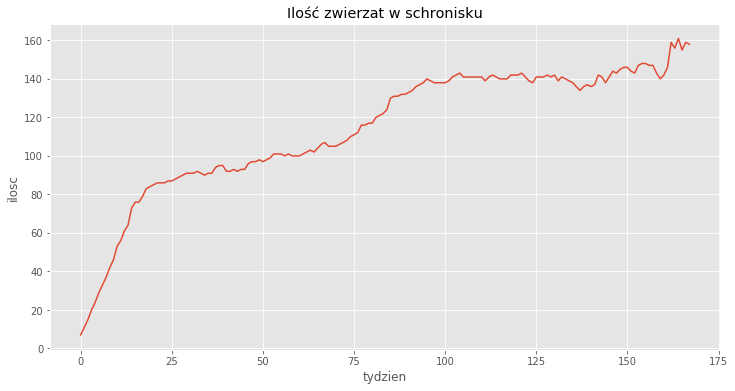

In [106]:
plt.style.use('ggplot')
plt.figure( figsize = (12,6) )
plt.plot(an_amount)
plt.title('Ilość zwierzat w schronisku')
plt.xlabel('tydzien')
plt.ylabel('ilosc')
plt.show()


### Ilość wolontariuszy

In [58]:
int_time = open_time
week = 30*24*3600 #1 dzien w sekundach- interwal czasowy
wol_amount = []
acc_amount = 0
ad_amount = 0
zw=0
a=0
while int_time< actual_time:
    start = dataformat(int_time)
    int_time += week
    end = dataformat(int_time)
    #nowe zwierzeta
    acc = ((df_wol.loc[df_wol['zatrudnienie'].between(start,end)]).count())[0]
    a+=acc
    #adoptowane lub zmarle
    ad = ((df_wol.loc[df_wol['rezygnacja'].between(start,end)]).count())[0]
    zw += ad
    #ilosc zwierzat ktora zostala przyjeta w tym tygodniu
    amount = acc  - ad
    acc_amount += amount
    #print(ad_amount)
    wol_amount.append(acc_amount)

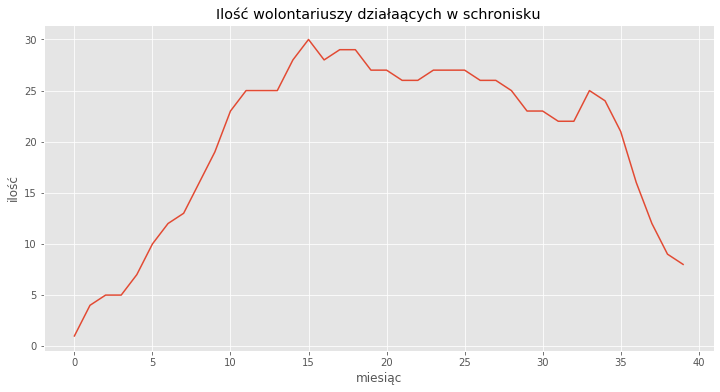

In [107]:
plt.style.use('ggplot')
plt.figure( figsize = (12,6) )
plt.plot(wol_amount)
plt.title('Ilość wolontariuszy działaących w schronisku')
plt.xlabel('miesiąc')
plt.ylabel('ilość')
plt.show()

###  Bilans schroniska

In [108]:
int_time = open_time
week = 40*24*3600 #1 dzien w sekundach- interwal czasowy
trans_amount = []
mi_amount = []
do_amount = []
while int_time< actual_time:
    start = dataformat(int_time)
    int_time += week
    end = dataformat(int_time)
    bilans  = (((df_trans.loc[df_trans['data'].between(start,end)]))['kwota'].values)
    ujemne = np.where(bilans<0, bilans, 0).sum()
    dodatnie = np.where(bilans>0, bilans, 0).sum()
    suma = bilans.sum()
    #print(ad_amount)
    mi_amount.append(ujemne)
    do_amount.append(dodatnie)
    trans_amount.append(suma)

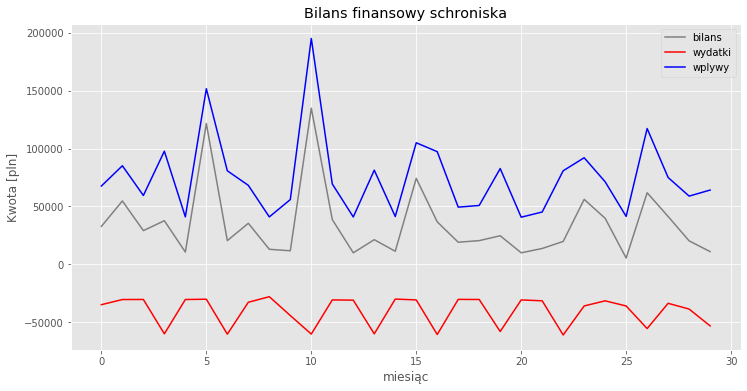

In [112]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(trans_amount, color = 'grey', label = 'bilans')
plt.plot(mi_amount, color = 'red', label = 'wydatki')
plt.plot(do_amount, color = 'blue', label = 'wplywy')
plt.title("Bilans finansowy schroniska")
plt.xlabel('miesiąc')
plt.ylabel('Kwota [pln]')
plt.legend(loc=1)
plt.show()

### Wiek zwierzat

In [64]:
for i in range(len(daty_ur)):
    timeu = actual_time - time.mktime(time.strptime(daty_ur[i], '%Y-%m-%d'))
    timeu = timeu/3600/24/365.5
    wiek.append(timeu)

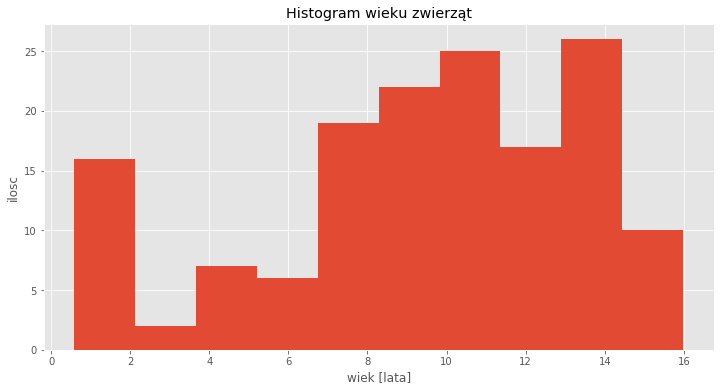

In [114]:
plt.figure(figsize = (12,6))
plt.hist(wiek)
plt.xlabel('wiek [lata]')
plt.ylabel('ilosc')
plt.title('Histogram wieku zwierząt')
plt.show()

In [129]:
szczury = df_info.loc[df_info['gatunek']=='szczur']
koty = df_info.loc[df_info['gatunek']=='kot']
psy = df_info.loc[df_info['gatunek']=='pies']
szczury = szczury['masa'].values
koty = koty['masa'].values
psy = psy['masa'].values


### Histogramy masy zwierząt

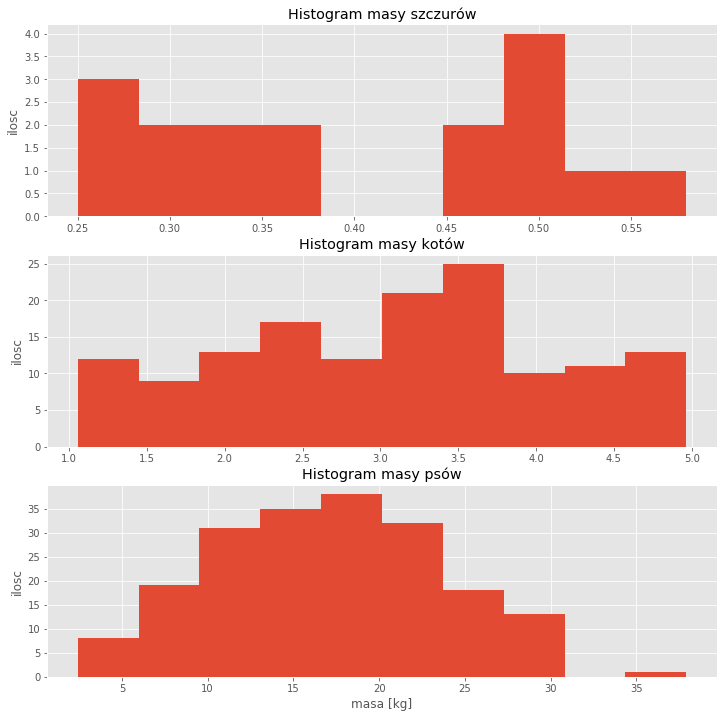

In [136]:
plt.figure(figsize = (12,12))
plt.subplot(311)
plt.hist(szczury)
plt.ylabel('ilosc')
plt.title('Histogram masy szczurów')
plt.subplot(312)
plt.hist(koty)
plt.ylabel('ilosc')
plt.title('Histogram masy kotów')
plt.subplot(313)
plt.hist(psy)
plt.xlabel('masa [kg]')
plt.ylabel('ilosc')
plt.title('Histogram masy psów')
plt.show()

## Usposobienie zwierząt w schronisku

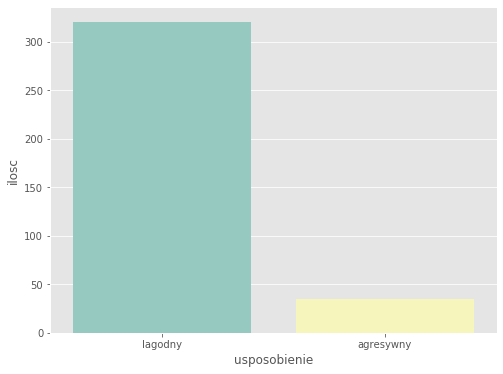

In [119]:
plt.figure(figsize=(8,6))
sns.countplot(x='inne_zwierzeta', data=df_info, palette='Set3')
df_info.loc[:,'inne_zwierzeta'].value_counts()
plt.ylabel('ilosc')
plt.xlabel('usposobienie')
plt.show()

## Stan zdrowia zwierząt

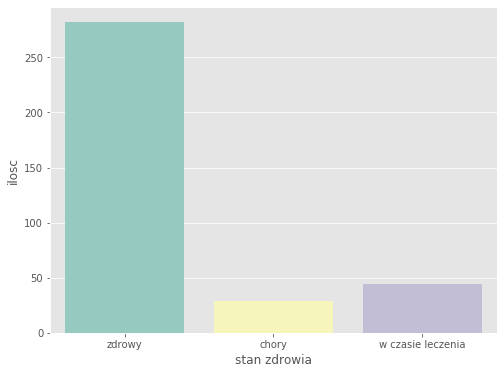

In [120]:
plt.figure(figsize=(8,6))
sns.countplot(x='stan_zdrowia', data=df_hist, palette='Set3')
df_hist.loc[:,'stan_zdrowia'].value_counts()
plt.ylabel('ilosc')
plt.xlabel('stan zdrowia')
plt.show()

## Gatunki zwierzat

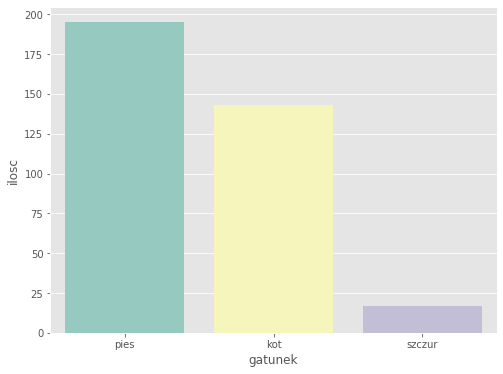

In [121]:
plt.figure(figsize=(8,6))
sns.countplot(x='gatunek', data=df_info, palette='Set3')
df_info.loc[:,'gatunek'].value_counts()
plt.ylabel('ilosc')
plt.xlabel('gatunek')
plt.show()

## Zwierzeta najdłużej czekające na adopcje

In [122]:
w_schr.sort_values(by = 'data_przyjecia',ascending = True).head(10)

,ID_opiekuna,blok,data_przyjecia,data_urodzenia,gatunek,id,id_gat,imie,inne_zwierzeta,masa,plec,stan,umaszczenie,wczesniej_adoptowany
39,[200001],B_28,2016-04-09,2011-11-30,pies,610039,1,Bajtek,lagodny,11.237,samiec,w schronisku,szary,nie
80,[200001],B_59,2016-04-12,2013-10-24,pies,610080,1,Leydis,lagodny,11.669,samica,w schronisku,czarny,nie
82,[200000],A_24,2016-04-22,2006-02-21,pies,610082,1,Ismena,agresywny,22.602,samica,w schronisku,rudy,nie
73,[200001],B_54,2016-04-28,2014-05-16,pies,610073,1,Bentlej,lagodny,13.303,samiec,w schronisku,biszkoptowy,nie
119,[200003],C_9,2016-05-02,2008-06-03,kot,620027,2,Tibia,lagodny,1.206,samica,w schronisku,bialo-rudy,nie
1,[200001],B_2,2016-05-02,2011-04-30,pies,610001,1,Chanelka,lagodny,13.091,samica,w schronisku,bialo-czarny,nie
15,[200001],B_12,2016-05-12,2007-08-08,pies,610015,1,Diablo,lagodny,10.441,samiec,w schronisku,bialo-brązowy,nie
90,[200001],B_65,2016-05-17,2010-05-12,pies,610090,1,Zoran,lagodny,10.302,samiec,w schronisku,bialo-rudy,nie
26,[200001],B_21,2016-05-23,2011-10-08,pies,610026,1,Begi,lagodny,13.886,samica,w schronisku,biszkoptowy,nie
40,[200001],B_29,2016-05-24,2012-08-04,pies,610040,1,Dzafara,lagodny,10.433,samica,w schronisku,bialo-czarny,nie


## Najstarsze zwierzęta w schronisku (5)

In [141]:
w_schr.sort_values(by = 'data_urodzenia',ascending = True).head(10)

,ID_opiekuna,blok,data_przyjecia,data_urodzenia,gatunek,id,id_gat,imie,inne_zwierzeta,masa,plec,stan,umaszczenie,wczesniej_adoptowany
103,[200003],C_3,2019-06-15,2003-06-25,kot,620011,2,Ama,lagodny,1.551,samica,w schronisku,bialy,tak
100,[200003],C_2,2019-06-14,2004-02-04,kot,620008,2,Lobo,lagodny,3.949,samiec,w schronisku,bialo-brązowy,tak
108,[200003],C_5,2019-01-30,2004-02-12,kot,620016,2,Marcel,agresywny,2.665,samiec,w schronisku,bialo-czarny,tak
110,[200003],C_6,2019-01-23,2004-03-31,kot,620018,2,Boti,lagodny,3.590,samica,w schronisku,bialo-szary,tak
116,[200003],C_8,2018-02-04,2004-04-17,kot,620024,2,Lamita,lagodny,1.056,samiec,w schronisku,rudy,tak
9,[200000],A_3,2019-05-04,2004-07-27,pies,610009,1,Lunia,lagodny,26.443,samica,w schronisku,bialo-rudy,tak
107,[200003],C_5,2016-08-23,2004-09-22,kot,620015,2,Pamela,lagodny,3.096,samica,w schronisku,szary,nie
16,[200001],B_13,2019-05-15,2004-11-02,pies,610016,1,Ozzy,lagodny,19.765,samiec,w schronisku,bialo-szary,tak
123,[200003],C_10,2019-06-11,2004-12-07,kot,620031,2,Kleks,lagodny,3.641,samiec,w schronisku,bialo-brązowy,nie
47,[200001],B_35,2018-07-16,2005-01-02,pies,610047,1,Bodzio,lagodny,15.215,samiec,w schronisku,biszkoptowy,tak


## Najmłodsze zwierzęta w schronisku (z podziałem na gatunki)

In [144]:
df_najp = df_info.loc[df_info['id_gat']==1]
df_najk = df_info.loc[df_info['id_gat']==2]
df_najs = df_info.loc[df_info['id_gat']==3]

### psy

In [145]:
df_najp.sort_values(by = 'data_urodzenia',ascending = False).head(10)

,Unnamed: 0,ID_opiekuna,blok,data_przyjecia,data_urodzenia,gatunek,id,id_gat,imie,inne_zwierzeta,masa,plec,stan,umaszczenie,wczesniej_adoptowany
75,75,['200001'],B_56,2017-01-30,2015-12-17,pies,610075,1,Tila,lagodny,12.470,samica,w schronisku,bialo-rudy,nie
62,62,['200000'],A_17,2018-10-21,2015-05-10,pies,610062,1,Nikus,lagodny,24.118,samiec,w schronisku,bialo-czarny,nie
81,81,['200000'],A_23,2018-10-21,2015-03-18,pies,610081,1,Grafit,lagodny,24.646,samiec,w schronisku,rudy,nie
44,44,['200001'],B_32,2019-01-27,2014-08-30,pies,610044,1,Roger,lagodny,17.579,samiec,w schronisku,biszkoptowy,tak
73,73,['200001'],B_54,2016-04-28,2014-05-16,pies,610073,1,Bentlej,lagodny,13.303,samiec,w schronisku,biszkoptowy,nie
23,23,['200001'],B_19,2018-01-31,2014-05-03,pies,610023,1,Ewer,lagodny,14.834,samiec,w schronisku,szary,nie
87,87,['200000'],A_26,2016-06-21,2014-02-12,pies,610087,1,Elvis,lagodny,28.165,samiec,w schronisku,bialo-brązowy,nie
348,348,['200001'],B_10,2015-12-08,2013-11-28,pies,631247,1,Anya,lagodny,15.750,samica,zmarly,bialo-brązowy,nie
80,80,['200001'],B_59,2016-04-12,2013-10-24,pies,610080,1,Leydis,lagodny,11.669,samica,w schronisku,czarny,nie
65,65,['200000'],A_18,2018-12-29,2013-07-28,pies,610065,1,Alpinos,lagodny,29.642,samiec,w schronisku,rudy,tak


### koty

In [146]:
df_najk.sort_values(by = 'data_urodzenia',ascending = False).head(10)

,Unnamed: 0,ID_opiekuna,blok,data_przyjecia,data_urodzenia,gatunek,id,id_gat,imie,inne_zwierzeta,masa,plec,stan,umaszczenie,wczesniej_adoptowany
99,99,['200003'],C_2,2018-04-29,2015-07-08,kot,620007,2,Hilton,agresywny,2.121,samiec,w schronisku,bialo-szary,nie
285,285,['200003'],C_30,2019-04-24,2014-06-14,kot,620090,2,Omar,lagodny,4.943,samiec,zaadoptowany,bialo-brązowy,tak
96,96,['200003'],C_1,2019-04-15,2014-04-22,kot,620004,2,Zoe,lagodny,1.175,samica,w schronisku,bialo-brązowy,tak
266,266,['200003'],C_23,2017-11-23,2014-03-22,kot,620071,2,Majki,lagodny,3.670,samiec,zaadoptowany,bialy,nie
351,351,['200003'],C_46,2015-03-30,2013-12-04,kot,632139,2,Uki,agresywny,2.619,samiec,zmarly,bialo-rudy,nie
304,304,['200003'],C_36,2018-10-23,2013-01-05,kot,620109,2,Haxel,lagodny,1.222,samiec,zaadoptowany,bialo-brązowy,nie
272,272,['200003'],C_25,2019-03-21,2012-12-02,kot,620077,2,Irbis,lagodny,3.512,samiec,zaadoptowany,czarny,nie
313,313,['200003'],C_39,2016-06-18,2011-12-21,kot,620118,2,Gomez,lagodny,4.409,samiec,zaadoptowany,bialo-rudy,nie
124,124,['200003'],C_10,2019-03-14,2011-11-17,kot,620032,2,Obi,lagodny,2.332,samiec,w schronisku,rudy,tak
247,247,['200003'],C_17,2016-04-06,2011-03-09,kot,620052,2,Anya,lagodny,2.615,samica,zaadoptowany,bialo-rudy,nie


### szczury

In [147]:
df_najs.sort_values(by = 'data_urodzenia',ascending = False).head(10)

,Unnamed: 0,ID_opiekuna,blok,data_przyjecia,data_urodzenia,gatunek,id,id_gat,imie,inne_zwierzeta,masa,plec,stan,umaszczenie,wczesniej_adoptowany
139,139,['200002'],B_0,2019-05-21,2018-11-20,szczur,630006,3,Agis,lagodny,0.471,samiec,w schronisku,czarny,nie
149,149,['200002'],B_0,2019-05-21,2018-08-04,szczur,630016,3,Lesiu,lagodny,0.499,samiec,w schronisku,szary,nie
133,133,['200002'],B_0,2019-05-21,2018-07-02,szczur,630000,3,Spata,lagodny,0.480,samica,w schronisku,bialo-szary,nie
148,148,['200002'],B_0,2019-05-21,2018-05-29,szczur,630015,3,Urwis,agresywny,0.346,samiec,w schronisku,bialo-czarny,nie
141,141,['200002'],B_0,2019-05-21,2018-05-06,szczur,630008,3,Cas,lagodny,0.496,samica,w schronisku,bialy,nie
138,138,['200002'],B_0,2019-05-21,2018-04-27,szczur,630005,3,Azbar,lagodny,0.349,samiec,w schronisku,bialy,nie
147,147,['200002'],B_0,2019-05-21,2018-03-28,szczur,630014,3,Jarwis,lagodny,0.546,samiec,w schronisku,szary,nie
145,145,['200002'],B_0,2019-05-21,2018-02-08,szczur,630012,3,Drop,lagodny,0.310,samiec,w schronisku,bialo-szary,nie
135,135,['200002'],B_0,2019-05-21,2018-02-03,szczur,630002,3,Nesli,lagodny,0.258,samica,w schronisku,bialo-czarny,nie
143,143,['200002'],B_0,2019-05-21,2018-02-03,szczur,630010,3,Luk,lagodny,0.349,samiec,w schronisku,brazowy,nie


## Największe kwoty darowizn na schronisko

In [137]:
trans_dar = df_trans.loc[df_trans['tytul']=='Darowizna']
trans_dar.sort_values(by ='kwota', ascending = False).head(10)

,data,id_transakcji,imie,kwota,nazwisko,tytul
1221,2016-11-07,570356,JAROSLAW,29615.76,BACZYNSKI,Darowizna
987,2016-11-28,570122,ZBIGNIEW,28492.13,KATARZYNSKI,Darowizna
1266,2019-03-15,570401,WIKTOR,27951.17,ZAJDEL,Darowizna
1206,2017-05-20,570341,WIESLAW,27133.74,KARPOWICZ,Darowizna
877,2016-11-21,570012,PIOTR,26289.24,BOCIAN,Darowizna
1042,2016-11-28,570177,SLAWOMIR,26217.77,SKROK,Darowizna
954,2017-12-25,570089,ADAM,25455.17,JANISZEK,Darowizna
1114,2017-05-12,570249,MIROSLA,25097.38,GAC,Darowizna
1269,2019-03-24,570404,WALDEMAR,24764.73,NIZINSKI,Darowizna
1040,2017-06-05,570175,MACIEJ,23732.63,MAJDA,Darowizna


## Najdłużej działający aktywni wolontariusze

In [138]:
(df_wol.loc[df_wol['rezygnacja']=='9999-99-99']).sort_values(by ='zatrudnienie', ascending = True).head(10)

,Unnamed: 0,adres,id,imie,nazwisko,rezygnacja,telefon,zatrudnienie
42,42,ul. Zytnia 43 Wroclaw,400042,MACIEJ,LUBA,9999-99-99,730-328-967,2016-12-07
20,20,ul. Luzycka 60 Wroclaw,400020,MARTA,KOLEK,9999-99-99,604-929-445,2017-01-20
32,32,ul. Gabriela Narutowicza 68 Wroclaw,400032,EWA,TOMASIEWICZ,9999-99-99,577-762-658,2017-01-23
54,54,ul. Agrestowa 73 Wroclaw,400054,LENA,KUBASIK,9999-99-99,827-892-929,2017-03-05
23,23,ul. Jastrzebia 97 Wroclaw,400023,MARTA,RADLINSKA,9999-99-99,740-621-958,2017-07-23
65,65,ul. Ogrodowa 65 Wroclaw,400065,TADEUSZ,JARECKI,9999-99-99,736-674-543,2017-12-02
8,8,ul. Koscielna 78 Wroclaw,400008,MAREK,LECH,9999-99-99,789-251-487,2018-02-17
61,61,ul. Jeczmienna 97 Wroclaw,400061,IZABELA,FRANCUZ,9999-99-99,639-502-499,2018-04-02
45,45,ul. Juliusza Slowackiego 3 Wroclaw,400045,ADAM,GRZEGORCZYK,9999-99-99,431-707-323,2018-04-22
56,56,ul. Ksiecia Jozefa Poniatowskiego 54 Wroclaw,400056,SYLWIA,SZCZECH,9999-99-99,402-735-442,2018-10-28


In [139]:
np.where(time.mktime(time.strptime('1980-12-01', '%Y-%m-%d'))<time.mktime(time.strptime(sel_byle['data'].values[1], '%Y-%m-%d'))
         <time.mktime(time.strptime('2200-12-01', '%Y-%m-%d')), 1, 0)

array(1)

In [74]:
((sel_info.loc[sel_info['data_przyjecia'].between('2018-11-01','2018-12-1')]).count())[0]


9

In [75]:
time.mktime(time.strptime('2200-12-01', '%Y-%m-%d'))

7286972400.0

In [76]:
joined_dates = pd.merge_asof(sel_byle, sel_info, left_on='id', right_on='id')